<a href="https://colab.research.google.com/github/YoonSungLee/AI-Innovation-Square_Vision/blob/master/Day%2015_Review%2C%20ResUnet%20tutorial/ResUnet_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Add
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch
    batch = np.random.choice(files, size = batch_size)
    
    #variables for collecting batches of inputs and outputs
    batch_x = [] # inputs : image
    batch_y = [] # outputs : mask
    
    
    for f in batch:

        #get the masks. Note that masks are png files
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 # background
        mask[mask != 0 ] = 1 # object
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2: # if the image is GRAY scale
          raw = np.stack((raw,)*3, axis=-1) # 1 channel GRAY image change to 3 channels GRAY image

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw) # raw.shape = (256, 256, 3)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. # batch_x.shape = (N, 256, 256, 3)
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)
    

### Python의 yield 키워드 알아보기
* https://tech.ssut.me/what-does-the-yield-keyword-do-in-python/

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

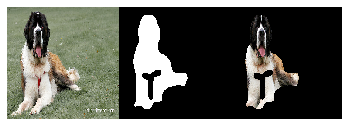

In [0]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# bce_dice_loss

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# loss function definition
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

<img src="https://i.imgur.com/g8AehnR.png" width="100%">

<img src="https://i.imgur.com/tuCJnpi.png" width="100%">

<img src="https://i.imgur.com/6aUob5F.png" width="100%">

<img src="https://i.imgur.com/09DU1iQ.png" width="100%">

# ResUnet

In [0]:
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding=padding, strides=strides)(x)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv


# def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
#     res = conv_block(x, filters, kernel_size, padding, strides)
#     res = conv_block(res, filters, kernel_size, padding, strides)
#     output = Add()([x, res])
#     return output

def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, kernel_size, padding, strides)
    res = conv_block(res, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, 1, kernel_initializer='he_normal', padding=padding, strides=strides)(x)
    # shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output

<img src="https://i.imgur.com/WpmvkGg.png" width="100%">

<img src="https://i.imgur.com/QMvJyyk.png" width="100%">

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #Contracting layers
  nKernels = 16
  layers = [] # for skip connection

  # level_1
  # level + layer
  layer11 = Conv2D(nKernels, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (x)
  layer11 = BatchNormalization()(layer11)
  layer11 = residual_block(layer11, nKernels)
  layers.append(layer11) # for skip connection
  layer13 = MaxPooling2D() (layer11)
  
  # level_2
  layer21 = Conv2D(nKernels*2, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer13)
  layer21 = BatchNormalization()(layer21)
  layer21 = residual_block(layer21, nKernels)
  layers.append(layer21) # for skip connection
  layer23 = MaxPooling2D() (layer21)

  # level_3
  layer31 = Conv2D(nKernels*4, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer23)
  layer31 = BatchNormalization()(layer31)
  layer31 = residual_block(layer31, nKernels)
  layers.append(layer31) # for skip connection
  layer33 = MaxPooling2D() (layer31)

  # level_4
  layer41 = Conv2D(nKernels*8, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer33)
  layer41 = BatchNormalization()(layer41)
  layer41 = residual_block(layer41, nKernels)
  layers.append(layer41) # for skip connection
  layer43 = MaxPooling2D() (layer41)

  # level_5
  layer51 = Conv2D(nKernels*16, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer43)
  layer51 = BatchNormalization()(layer51)
  layer51 = residual_block(layer51, nKernels)
  layers.append(layer51) # for skip connection
  layer53 = MaxPooling2D() (layer51)

  # level_6
  layer61 = Conv2D(nKernels*32, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer53)
  layer61 = BatchNormalization()(layer61)
  layer61 = residual_block(layer61, nKernels)
  layers.append(layer61) # for skip connection
  layer63 = MaxPooling2D() (layer61)
  
  # BottleNeck
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer63)
  bottleneck11 = BatchNormalization()(bottleneck11)
  bottleneck12 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (bottleneck11)
  bottleneck12 = BatchNormalization()(bottleneck12)
  bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), padding='same') (bottleneck12)
  level = len(layers) - 1 # 6-1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]]) # (B, H, W, C) == axis(0,1,2,3)
  
  # level 7 = level 6
  layer71 = Conv2D(nKernels*32, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer71)
  layer71 = BatchNormalization()(layer71)
  layer72 = residual_block(layer71, nKernels)
  layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), padding='same') (layer72)
  level = len(layers) - 2 # 6-2
  layer81 = Concatenate(axis=3)([layer74, layers[level]])
  
  # level 8 = level 5
  layer81 = Conv2D(nKernels*16, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer81)
  layer81 = BatchNormalization()(layer81)
  layer82 = residual_block(layer81, nKernels)
  layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), padding='same') (layer82)
  level = len(layers) - 3 # 6-3
  layer91 = Concatenate(axis=3)([layer84, layers[level]])

  # level 9 = level 4
  layer91 = Conv2D(nKernels*8, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer91)
  layer91 = BatchNormalization()(layer91)
  layer92 = residual_block(layer91, nKernels)
  layer94 = Conv2DTranspose(nKernels, 2, strides=(2, 2), padding='same') (layer92)
  level = len(layers) - 4 # 6-4
  layer101 = Concatenate(axis=3)([layer94, layers[level]])

  # level 10 = level 3
  layer101 = Conv2D(nKernels*4, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer101)
  layer101 = BatchNormalization()(layer101)
  layer102 = residual_block(layer101, nKernels)
  layer104 = Conv2DTranspose(nKernels, 2, strides=(2, 2), padding='same') (layer102)
  level = len(layers) - 5 # 6-5
  layer111 = Concatenate(axis=3)([layer104, layers[level]])
  
  # level 11 = level 2
  layer111 = Conv2D(nKernels*2, 1, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer111)
  layer112 = BatchNormalization()(layer111)
  layer112 = residual_block(layer112, nKernels)
  layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), padding='same') (layer112)
  level = len(layers) - 6 # 6-6
  layer121 = Concatenate(axis=3)([layer114, layers[level]])
      
  #level 1 = classification 
  classification1 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer121)
  classification1 = BatchNormalization()(classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (classification1)
  classification2 = BatchNormalization()(classification2)
  outputs = Conv2D(1, 1, activation='sigmoid') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [mean_iou])
  
  return model

In [0]:
model = unet()
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 48          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization_1[0][0]      
____________________________________________________________________________________________

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training



i= 1 loss= 0.7182590233408697 val_loss= 0.9696174426512285 mean_iou= 0.5425126770996067 val_mean_iou= 0.5914799571037292


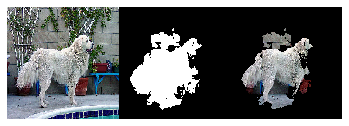

i= 2 loss= 0.5008617220403941 val_loss= 0.5311900025064294 mean_iou= 0.6522488302836135 val_mean_iou= 0.6736695116216486


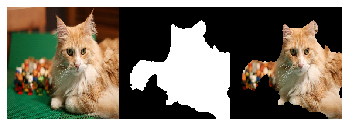

i= 3 loss= 0.42434742352733873 val_loss= 0.45694763281128625 mean_iou= 0.6999602796824556 val_mean_iou= 0.7008945887739008


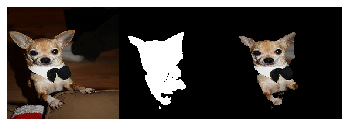

i= 4 loss= 0.38061750125667276 val_loss= 0.4365798234939575 mean_iou= 0.7276002838187021 val_mean_iou= 0.6740909977392717


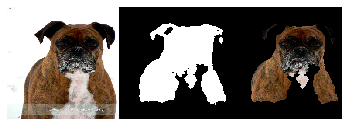

i= 5 loss= 0.34728189731297426 val_loss= 0.4029551419344815 mean_iou= 0.7507101436183877 val_mean_iou= 0.7296758185733448


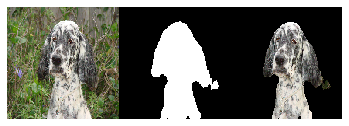

i= 6 loss= 0.31448650639078934 val_loss= 0.3926084339618683 mean_iou= 0.7726822310386727 val_mean_iou= 0.740323933688077


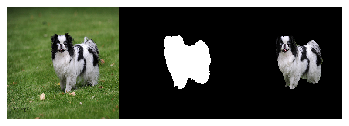

i= 7 loss= 0.28257251554700336 val_loss= 0.37029166655106976 mean_iou= 0.7943462650525516 val_mean_iou= 0.7517144138162787


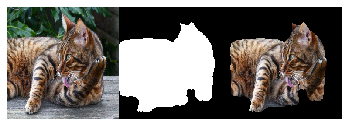

i= 8 loss= 0.25493573019765825 val_loss= 0.35714383016933093 mean_iou= 0.8128477430234761 val_mean_iou= 0.7721880132501776


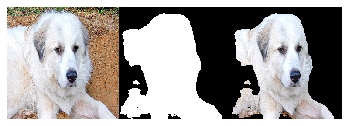

i= 9 loss= 0.23935624875434458 val_loss= 0.348692002621564 mean_iou= 0.8229366734147616 val_mean_iou= 0.7709779468449679


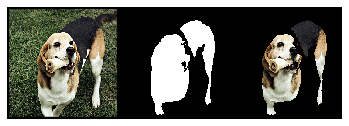

i= 10 loss= 0.2153042679371899 val_loss= 0.4167368466203863 mean_iou= 0.8404920071227365 val_mean_iou= 0.7403059222481467


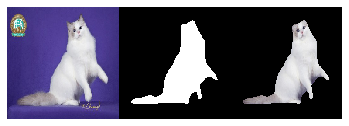

i= 11 loss= 0.2006805646637259 val_loss= 0.37876116687601263 mean_iou= 0.8490574871568375 val_mean_iou= 0.754119482907382


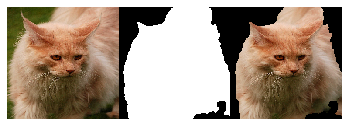

i= 12 loss= 0.18565279728473594 val_loss= 0.37966578115116467 mean_iou= 0.8598799506823221 val_mean_iou= 0.7414994510737333


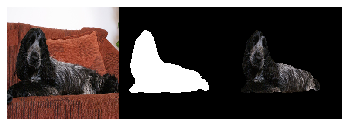

i= 13 loss= 0.1730615223787691 val_loss= 0.3677026195959611 mean_iou= 0.8690263141780139 val_mean_iou= 0.7668392766605724


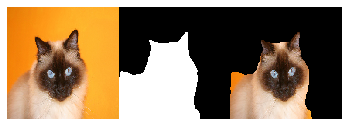

i= 14 loss= 0.16411984977248598 val_loss= 0.36830308762463654 mean_iou= 0.8749400260241609 val_mean_iou= 0.7569475499066439


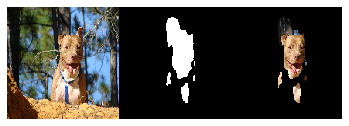

i= 15 loss= 0.15614098895630335 val_loss= 0.3166180578145114 mean_iou= 0.8808290585535302 val_mean_iou= 0.7881302345882762


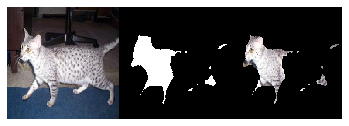

i= 16 loss= 0.1464636574188868 val_loss= 0.3601753359491175 mean_iou= 0.8871466057485642 val_mean_iou= 0.7544204538518732


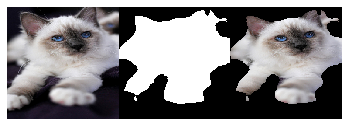

i= 17 loss= 0.14118768584374422 val_loss= 0.35767106305469165 mean_iou= 0.8907794783648835 val_mean_iou= 0.7603231072425842


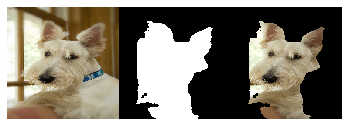

i= 18 loss= 0.1317025926559483 val_loss= 0.38168762759728864 mean_iou= 0.8974978439339764 val_mean_iou= 0.7626037760214373


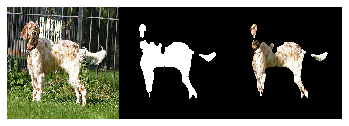

i= 19 loss= 0.1268618526660144 val_loss= 0.3344298167662187 mean_iou= 0.9008217639030387 val_mean_iou= 0.7810487096959894


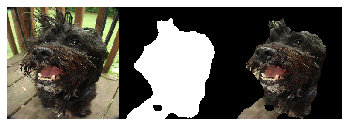

i= 20 loss= 0.12388629061446342 val_loss= 0.402423232793808 mean_iou= 0.9029078295786087 val_mean_iou= 0.7546012943441217


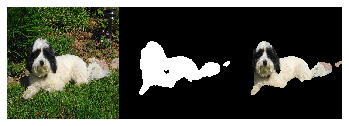

i= 21 loss= 0.12022480919753036 val_loss= 0.391659368168224 mean_iou= 0.905491179527213 val_mean_iou= 0.7724837985905734


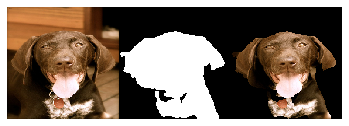

i= 22 loss= 0.11267861206781919 val_loss= 0.3617743253707886 mean_iou= 0.9119842624011105 val_mean_iou= 0.7554286068136041


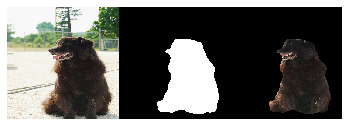

i= 23 loss= 0.1077461429790819 val_loss= 0.3725590136918155 mean_iou= 0.9154618945840287 val_mean_iou= 0.7644948580048301


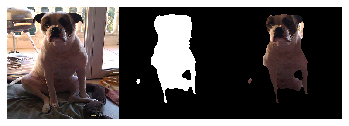

i= 24 loss= 0.10741315081239292 val_loss= 0.33622709729454736 mean_iou= 0.9150573200286796 val_mean_iou= 0.7844223542646929


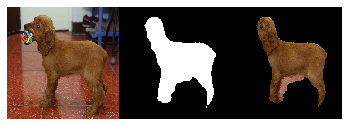

i= 25 loss= 0.10253057635674194 val_loss= 0.3710832026871768 mean_iou= 0.9184905554605945 val_mean_iou= 0.7655862136320635


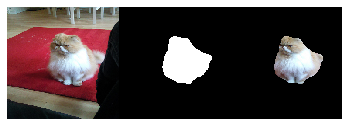

i= 26 loss= 0.09812061811827089 val_loss= 0.39491657506335864 mean_iou= 0.9218933457108938 val_mean_iou= 0.7724567218260332


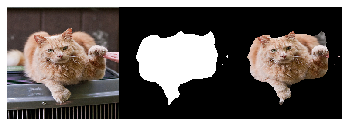

i= 27 loss= 0.09634471909232335 val_loss= 0.3251224160194397 mean_iou= 0.922820218621868 val_mean_iou= 0.8072460347955878


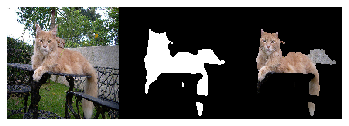

i= 28 loss= 0.09248593946297963 val_loss= 0.42680950327353046 mean_iou= 0.9264585675169889 val_mean_iou= 0.7485639236190103


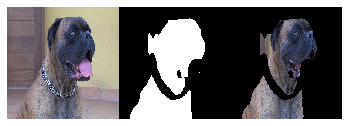

i= 29 loss= 0.09024612544334099 val_loss= 0.35431880029765045 mean_iou= 0.927670211552485 val_mean_iou= 0.7780087102543224


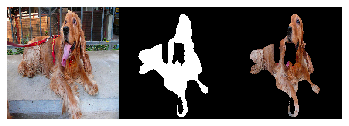

i= 30 loss= 0.0874560743094035 val_loss= 0.382307613437826 mean_iou= 0.9297358445380921 val_mean_iou= 0.785454966805198


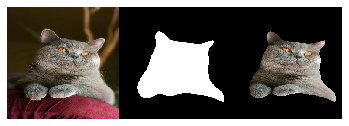

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0) # verbose : 0=학습로고표시안함, 1=표시함

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-07 09:48:01--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 54.240.168.91, 54.240.168.63, 54.240.168.97, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|54.240.168.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.006s  

2020-03-07 09:48:01 (10.5 MB/s) - ‘test.jpg’ saved [63219/63219]



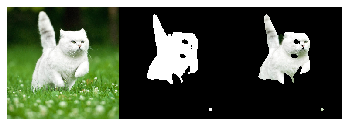

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet



# 성능을 더 높이는 방법

* BottleNeck 제거
* BatchNormalization Layer 적용
* kernel_initializer = 'he_normal'
* FeatureMap의 개수(nKernels) 증가
* top layer부분에 Dropout 적용
* 마지막 layer의 activation function을 'sigmoid'에서 'softmax'로 변경
 * outputs = Conv2D(2, 1, activation='softmax') (classification2)
* loss function을 bce_dice_loss로 변경
* encoding과 decoding의 level을 증가시키는 방법은 overfitting이 발생할 수 있기 때문에 효과적인 방법은 아님